In [1]:
import logging
from pathlib import Path
from IPython.core.display import SVG

from Pegasus.api import *

logging.basicConfig(level=logging.DEBUG)

# Using Containers

The workflow illustrated here is a simple processing pipeline that uses a **Docker container** for two of its jobs. These jobs are colored in light blue. The first containerized job, `preprocess`, runs the executable `/usr/local/bin/preprocess.sh` inside of the container. Note that this executable is part of the container image. The second containerized job, `process_text_more`, transfers the executable `process_text_2nd_pass.py` via **HTTP** from `http://isi.edu/~tanaka/process_text_2nd_pass.py`, into the container where it will be executed.  

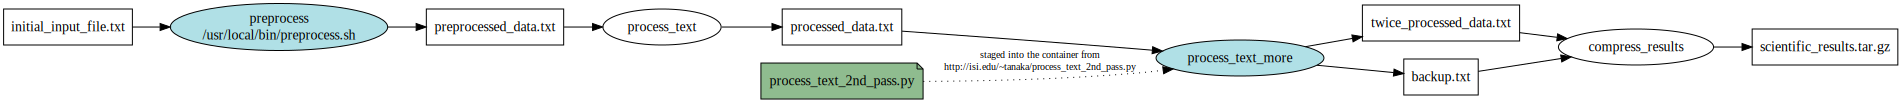

In [2]:
SVG("diagram.svg")

In [3]:
# --- Transformation Catalog -----------------------------------------------
tc = TransformationCatalog()

# Create and add our containers to the TransformationCatalog.

# A container that will be used to execute the following two transformations.
tools_container = Container(
                    "tools-container", 
                    Container.DOCKER, 
                    image="docker:///ryantanaka/preprocess:latest"
                )

tc.add_containers(tools_container)

# Create and add our transformations to the TransformationCatalog.

# An executable that is installed inside of "tools_container".
preprocess = Transformation(
                "preprocess",
                site="condorpool",
                pfn="/usr/local/bin/preprocess.sh",
                is_stageable=False,
                container=tools_container
            )

# A shell script that can be staged to some site and executed.
process_text = Transformation(
                    "process_text.sh", 
                    site="local", 
                    pfn=Path(".").resolve() / "bin/process_text.sh", 
                    is_stageable=True
                )

# A stageable python script that must be executed inside tools_container because
# it contains packages that we have when we develop locally, but may not be 
# installed on a compute node. 
process_text_2nd_pass = Transformation(
                            "process_text_2nd_pass.py",
                            site="workflow-cloud",
                            pfn="http://www.isi.edu/~tanaka/process_text_2nd_pass.py",
                            is_stageable=True,
                            container=tools_container
                        )

# An binary that is already installed on the condorpool site.
tar = Transformation(
        "tar",
        site="condorpool",
        pfn="/usr/bin/tar",
        is_stageable=False
    )

tc.add_transformations(preprocess, process_text, process_text_2nd_pass, tar)
tc.write()

# --- Replica Catalog ----------------------------------------------------------
initial_input_file = File("initial_input_file.txt").add_metadata(size=54)

rc = ReplicaCatalog()\
        .add_replica("local", "initial_input_file.txt", Path(".").resolve() / "initial_input_file.txt")\
        .write()

# --- Workflow -----------------------------------------------------------------
props = Properties()
props["dagman.retry"] = "1"
props["pegasus.transfer.arguments"] = "-m 1"
props.write()

condorpool = Site("condorpool")\
                .add_pegasus_profile(style="condor")\
                .add_pegasus_profile(auxillary_local="true")\
                .add_condor_profile(universe="vanilla")
sc = SiteCatalog()
sc.add_sites(condorpool)
sc.write()

wf = Workflow("docker-wf")

preprocessed_data = File("preprocessed_data.txt")

job_preprocess = Job(preprocess)\
                    .add_args(initial_input_file, preprocessed_data)\
                    .add_inputs(initial_input_file)\
                    .add_outputs(preprocessed_data)

processed_data = File("processed_data.txt")

job_process_text = Job(process_text)\
                    .add_args(preprocessed_data, processed_data)\
                    .add_inputs(preprocessed_data)\
                    .add_outputs(processed_data)

twice_processed_data = File("twice_processed_data.txt")
extra_copy = File("backup.txt")

job_process_text_more = Job(process_text_2nd_pass)\
                            .add_args(processed_data, twice_processed_data, extra_copy)\
                            .add_inputs(processed_data)\
                            .add_outputs(twice_processed_data, extra_copy)

result = File("scientific_results.tar.gz")
compress = Job(tar, _id="tar_job")\
            .add_args("-cvzf", result, twice_processed_data, extra_copy)\
            .add_inputs(*job_process_text_more.get_outputs())\
            .add_outputs(result)

wf.add_jobs(
    job_preprocess,
    job_process_text,
    job_process_text_more,
    compress
)

try:
    wf.plan(submit=True)\
        .wait()\
        .analyze()\
        .statistics()
except PegasusClientError as e:
    print(e.output)




################
# pegasus-plan #
################
[main] WARN  schema.JsonMetaSchema  - Unknown keyword $defs - you should define your own Meta Schema. If the keyword is irrelevant for validation, just use a NonValidationKeyword
[main] WARN  schema.JsonMetaSchema  - Unknown keyword additionalItems - you should define your own Meta Schema. If the keyword is irrelevant for validation, just use a NonValidationKeyword
[main] WARN  schema.JsonMetaSchema  - Unknown keyword examples - you should define your own Meta Schema. If the keyword is irrelevant for validation, just use a NonValidationKeyword
2020.08.07 04:09:21.585 UTC:
2020.08.07 04:09:21.591 UTC:   -----------------------------------------------------------------------
2020.08.07 04:09:21.597 UTC:   File for submitting this DAG to HTCondor           : docker-wf-0.dag.condor.sub
2020.08.07 04:09:21.602 UTC:   Log of DAGMan debugging messages                 : docker-wf-0.dag.dagman.out
2020.08.07 04:09:21.608 UTC:   Log of HTCondor

[#########-----------------------------------------]  18.2% ..Failure (Completed: 4, Queued: 0, Running: 1, Failed: 0)



####################
# pegasus-analyzer #
####################
Your database is compatible with Pegasus version: 5.0.0dev

************************************Summary*************************************

Submit Directory   : /home/scitech/shared-data/sample-docker-wf/scitech/pegasus/docker-wf/run0002
Total jobs         :     22 (100.00%)
# jobs succeeded   :      4 (18.18%)
# jobs failed      :      0 (0.00%)
# jobs held        :      0 (0.00%)
# jobs unsubmitted :     18 (81.82%)



######################
# pegasus-statistics #
######################
Your database is compatible with Pegasus version: 5.0.0dev

#
# Pegasus Workflow Management System - http://pegasus.isi.edu
#
# Workflow summary:
#   Summary of the workflow execution. It shows total
#   tasks/jobs/sub workflows run, how many succeeded/failed etc.
#   In case of hierarchical workflow the calculation shows the
#   statistics across all the sub workflows.It shows the following
#   statistics about tasks, jobs and sub work